## Criar diagrama dos dataframes

## PEQUENO RESUMO

## Table of contents

0. [Imports](#imports)    
1. [Performace analysis](#performance_analysis)       
2. [Finding the best subset](#finding)      
3. [Reconstructing the top models](#reconstructing)    
4. [ROC curves](#roc_curves)    
5. [Regression plots](#regression)    
6. [Supplementary data](#supplementary)    
    1. [Correlations](#correlations)    
    2. [Comparing models and labels](#comparing)   
    3. [Docking scores and performance increment](#docking)    
    4. [Top descriptors](#top_descriptors)    
    5. [Confusion matrix for the best model](#confusion_matrix)     
    
<a id='imports'></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

In [2]:
# Read data
data = pd.read_csv('data.csv')

# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Descriptors
descriptors_list = list(descriptors.columns[1:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']
trainset = descriptors_list + docking_list

# Test metrics
scoring_metrics = ['accuracy','precision','recall','f1','f2','geometric_mean','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]
columns = [*test_metrics, 'activity_label', 'model', 'random_state'] + trainset

In [4]:
# Read test scores and sort values
local = False
if local:
    # Local computer
    scores_data = pd.read_csv('scores_data.csv')
else:
    # Cluster results
    scores_data = pd.read_csv('scores_data_cluster.csv.gz', compression='gzip')
    # Groupby "job_id" and get mean of random states (https://stackoverflow.com/a/65028508/13131079)
    d = {True: 'mean', False: 'first'}
    agg_map = {col: d[pd.api.types.is_numeric_dtype(i)] for col, i in zip(
        scores_data.columns, scores_data.dtypes)}
    scores_data = scores_data.groupby('job_id').agg(agg_map).drop(
        ['job_id','random_state'], axis=1).reset_index(drop=True)
    
columns = scores_data.columns
selected = ['test_f2', 'test_geometric_mean', 'test_roc_auc']

# Scale results
#scores_data[test_metrics] = StandardScaler().fit_transform(scores_data[test_metrics])
scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.head()

,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_geometric_mean,test_roc_auc,activity_label,model,MolMR,...,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
9249,0.726683,0.283225,0.625213,0.389171,0.502656,0.680573,0.684129,f_active,KNeighborsClassifier,0,...,1,1,0,0,1,1,1,0,0,0.622453
4990,0.708826,0.277853,0.638086,0.386694,0.506076,0.676698,0.679400,r_active,LinearDiscriminantAnalysis,0,...,1,1,1,0,0,0,0,1,0,0.620725
5004,0.708826,0.277853,0.638086,0.386694,0.506076,0.676698,0.679400,r_active,LinearDiscriminantAnalysis,0,...,1,1,0,1,0,0,0,1,0,0.620725
6174,0.742996,0.302922,0.601216,0.401739,0.500927,0.676817,0.684034,r_active,LogisticRegression,0,...,1,1,1,1,1,0,0,1,1,0.620593
6082,0.710312,0.278607,0.636173,0.386983,0.505492,0.676427,0.679470,r_active,LinearDiscriminantAnalysis,0,...,1,1,1,1,0,0,0,1,1,0.620463


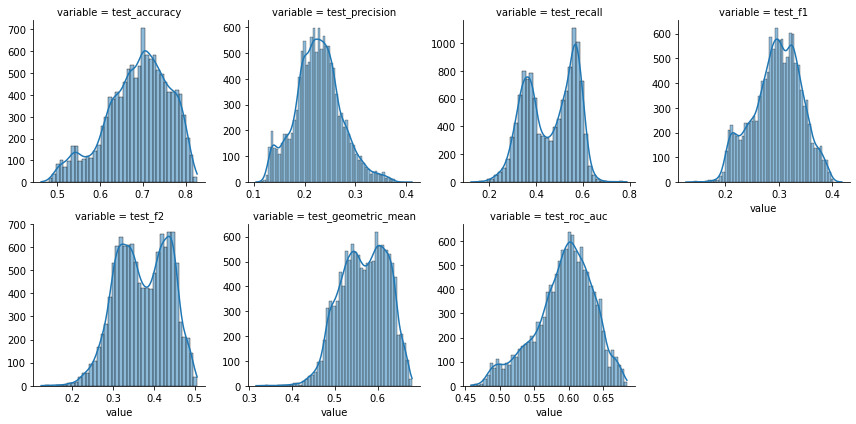

In [5]:
tmp = pd.melt(scores_data, value_vars=test_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)

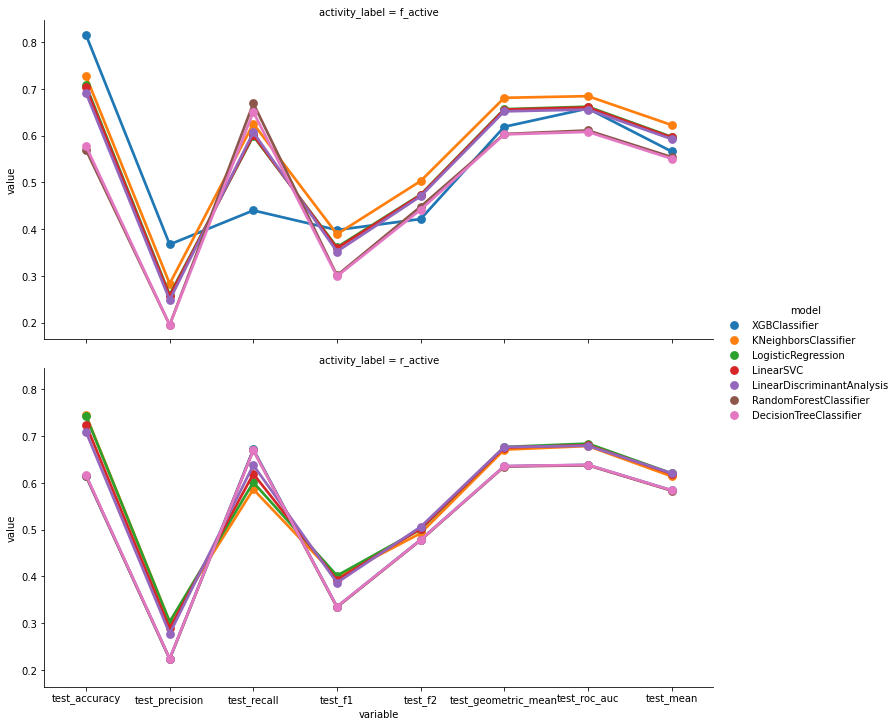

In [6]:
top = pd.melt(scores_data.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2, order=[*test_metrics,'test_mean'])
plt.savefig('test_performance.png', dpi=128)

<a id='finding'></a>
### Finding the best subset

In [7]:
# Dictionary: key == model_name, value == list of best descriptors
best_subset = {}

activity_label = 'f_active'
for i, row in scores_data.query('activity_label == @activity_label').groupby('model').head(1).iterrows():
    best_subset[row['model']] = [descriptor for descriptor in trainset if row[descriptor]]

<a id='reconstructing'></a>
### Reconstructing the top models

In [8]:
def get_model_by_name(model_name):
    if model_name == 'LogisticRegression':
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        return CalibratedClassifierCV(LinearSVC(dual=False, random_state=13))
    elif model_name == 'RandomForestClassifier':
        return RandomForestClassifier(n_estimators=10, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'XGBClassifier':
        return XGBClassifier(objective='reg:logistic', random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        return DecisionTreeClassifier(random_state=13)
    elif model_name == 'LinearDiscriminantAnalysis':
        return LinearDiscriminantAnalysis(solver='svd')
    return None

In [9]:
# Probabilities for the top models
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# List of scores for the top models
scores_list = []
new_data = data.dropna(subset=trainset)

test_metrics = selected
train_metrics = [i.replace('test', 'train') for i in selected]
scoring_metrics = test_metrics + train_metrics

count = 0
for key, value in best_subset.items():
    model_name = key
    subset = value
    
    y = new_data[activity_label]
    X = new_data[subset]
            
    scaler = StandardScaler()
    pipe = make_pipeline(SMOTE(random_state=42), scaler, get_model_by_name(model_name))
        
    metrics_dict = {key: [] for key in scoring_metrics}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        
        # Test predictions
        y_pred = model_fitted.predict(X_test)
        metrics_dict['test_f2'].append(fbeta_score(y_test, y_pred, beta=2)) # test_f2
        metrics_dict['test_geometric_mean'].append(geometric_mean_score(y_test, y_pred)) # test_geometric_mean
        metrics_dict['test_roc_auc'].append(roc_auc_score(y_test, y_pred)) # test_roc_auc
        
        # Training predictions
        y_pred = model_fitted.predict(X_train)
        metrics_dict['train_f2'].append(fbeta_score(y_train, y_pred, beta=2)) # train_f2
        metrics_dict['train_geometric_mean'].append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
        metrics_dict['train_roc_auc'].append(roc_auc_score(y_train, y_pred)) # train_roc_auc
    
    # Mean of the KFold scores
    scores = [np.mean(value) for value in metrics_dict.values()]
    scores_list.append([model_name, *scores])
    
    y_proba_train = model_fitted.predict_proba(X_train)
    train_data[model_name] = y_proba_train[:,1]

    y_proba_test = model_fitted.predict_proba(X_test)
    test_data[model_name] = y_proba_test[:,1]
    
    # Keep original indices
    test_data.index = X_test.index
    count+=1

columns = ['model', *scoring_metrics]
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics].mean(axis=1)

<a id='roc_curves'></a>
### ROC curves

,model,test_f2,test_geometric_mean,test_roc_auc,train_f2,train_geometric_mean,train_roc_auc,test_mean,train_mean
0,KNeighborsClassifier,0.488625,0.668802,0.675488,0.750884,0.860917,0.861536,0.610971,0.824445
1,LogisticRegression,0.460125,0.648230,0.655024,0.481066,0.663653,0.668392,0.587793,0.604370
2,LinearSVC,0.461524,0.650235,0.658530,0.479848,0.663562,0.668870,0.590096,0.604093
3,LinearDiscriminantAnalysis,0.468086,0.651881,0.654703,0.478048,0.658888,0.661797,0.591557,0.599578
4,XGBClassifier,0.358880,0.564848,0.627623,0.996928,0.998079,0.998084,0.517117,0.997697
5,RandomForestClassifier,0.446934,0.599150,0.603920,0.518134,0.653125,0.665723,0.550002,0.612327
6,DecisionTreeClassifier,0.445666,0.606925,0.609841,0.520941,0.665159,0.674453,0.554144,0.620184


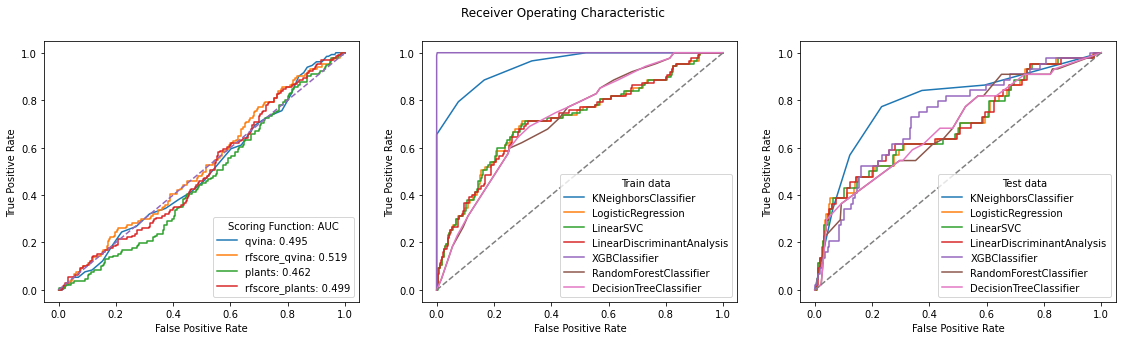

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(19.2, 4.8))

# Plot ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data[activity_label].values, data[SF].values)
    ax[0].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[1].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[2].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(3):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Scoring Function: AUC', loc='lower right')
ax[1].legend(title='Train data')
ax[2].legend(title='Test data')

plt.suptitle('Receiver Operating Characteristic')
plt.savefig('test_roc_curve.png', dpi=216)

# CONFERIR GRAFICO DO VINA

top_scores

<a id='supplementary'></a>
## Supplementary data
<a id='comparing'></a>
### Comparing models and labels

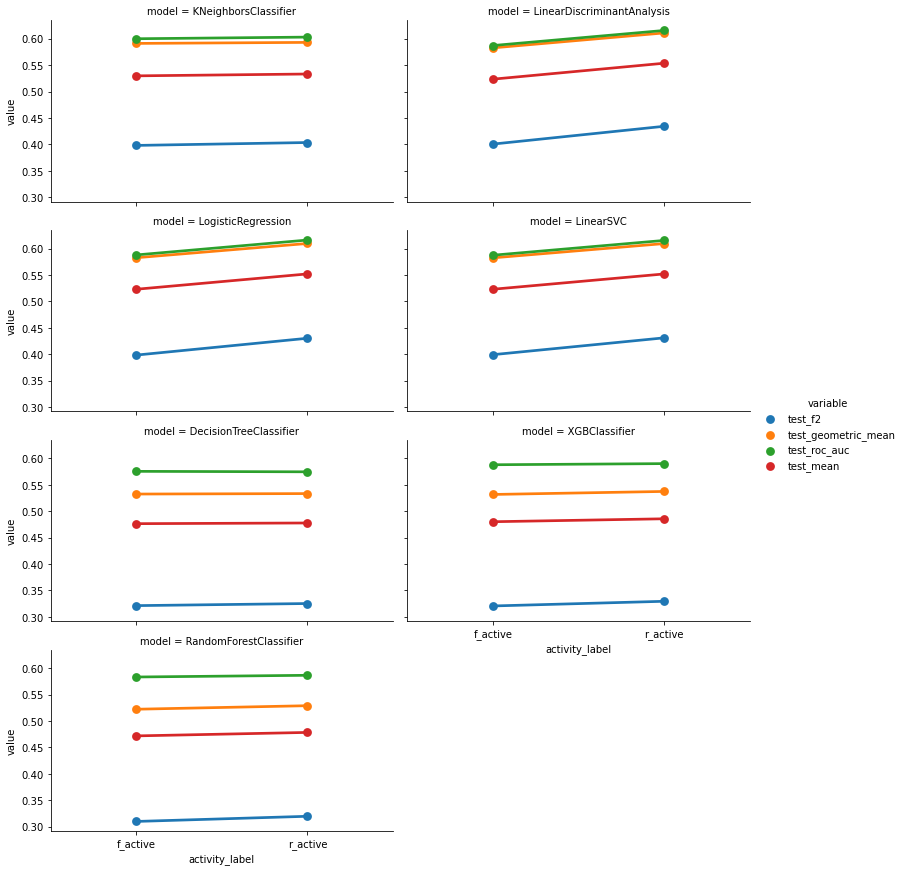

In [11]:
melt = pd.melt(scores_data, id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=melt, x='activity_label', y='value', hue='variable', col='model', col_wrap=2, height=3, aspect=1.75)

In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(scores_data.groupby(['model','activity_label']).describe())

test_accuracy                      \
                                                  count      mean       std   
model                      activity_label                                     
DecisionTreeClassifier     f_active               884.0  0.725413  0.029894   
                           r_active               884.0  0.720027  0.029589   
KNeighborsClassifier       f_active               884.0  0.661659  0.036880   
                           r_active               884.0  0.671028  0.041633   
LinearDiscriminantAnalysis f_active               884.0  0.614199  0.055422   
                           r_active               884.0  0.647911  0.057530   
LinearSVC                  f_active               884.0  0.618598  0.057875   
                           r_active               884.0  0.654229  0.060932   
LogisticRegression         f_active               884.0  0.622492  0.059025   
                           r_active               884.0  0.658780  0.062980   
RandomForestClassifier     f_active               884.0  0.763680  0.036832   
                           r_active               884.0  0.760370  0.036955   
XGBClassifier              f_active               884.0  0.760510  0.040864   
                           r_active               884.0  0.755576  0.040083   

                                                                         \
                                                min       25%       50%   
model                      activity_label                                 
DecisionTreeClassifier     f_active        0.577041  0.713101  0.730288   
                           r_active        0.580019  0.707243  0.724839   
KNeighborsClassifier       f_active        0.555358  0.636558  0.668548   
                           r_active        0.562885  0.643330  0.675734   
LinearDiscriminantAnalysis f_active        0.462953  0.568686  0.622891   
                           r_active        0.481452  0.608501  0.665298   
LinearSVC                  f_active        0.464660  0.569029  0.628172   
                           r_active        0.482934  0.609238  0.674472   
LogisticRegression         f_active        0.468071  0.569607  0.636985   
                           r_active        0.483279  0.611990  0.679895   
RandomForestClassifier     f_active        0.567437  0.747405  0.769042   
                           r_active        0.575869  0.743750  0.767525   
XGBClassifier              f_active        0.573151  0.739428  0.772735   
                           r_active        0.580358  0.736546  0.764821   

                                                              test_precision  \
                                                75%       max          count   
model                      activity_label                                      
DecisionTreeClassifier     f_active        0.744911  0.783846          884.0   
                           r_active        0.740316  0.783395          884.0   
KNeighborsClassifier       f_active        0.687502  0.759022          884.0   
                           r_active        0.703433  0.756089          884.0   
LinearDiscriminantAnalysis f_active        0.656227  0.707112          884.0   
                           r_active        0.691251  0.737560          884.0   
LinearSVC                  f_active        0.660023  0.713366          884.0   
                           r_active        0.701124  0.743039          884.0   
LogisticRegression         f_active        0.660575  0.715033          884.0   
                           r_active        0.708162  0.742996          884.0   
RandomForestClassifier     f_active        0.788045  0.822312          884.0   
                           r_active        0.784776  0.826435          884.0   
XGBClassifier              f_active        0.790125  0.823055          884.0   
                           r_active        0.783526  0.816409          884.0   

                                                             

<a id='docking'></a>
### Docking scores and performance increment

Text(0.5, 1.05, 'test_roc_auc')

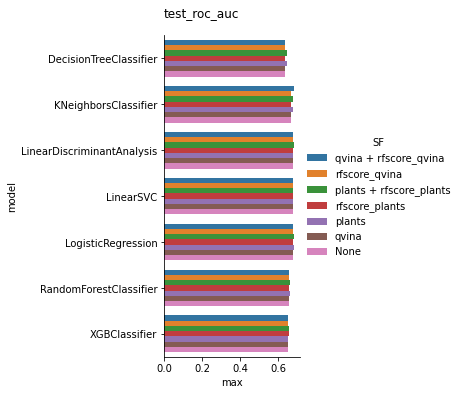

In [13]:
'''
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]
'''

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

#compare = pd.melt(df, id_vars=['model','SF'], value_vars=['mean','max'])
sns.catplot(kind='bar', data=df, y='model', x='max', hue='SF')
plt.suptitle('test_roc_auc', y=1.05)

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.

<a id='top_descriptors'></a>
### Top descriptors

Text(0.5, 0.98, 'Most frequent descriptors in the top 1% scores')

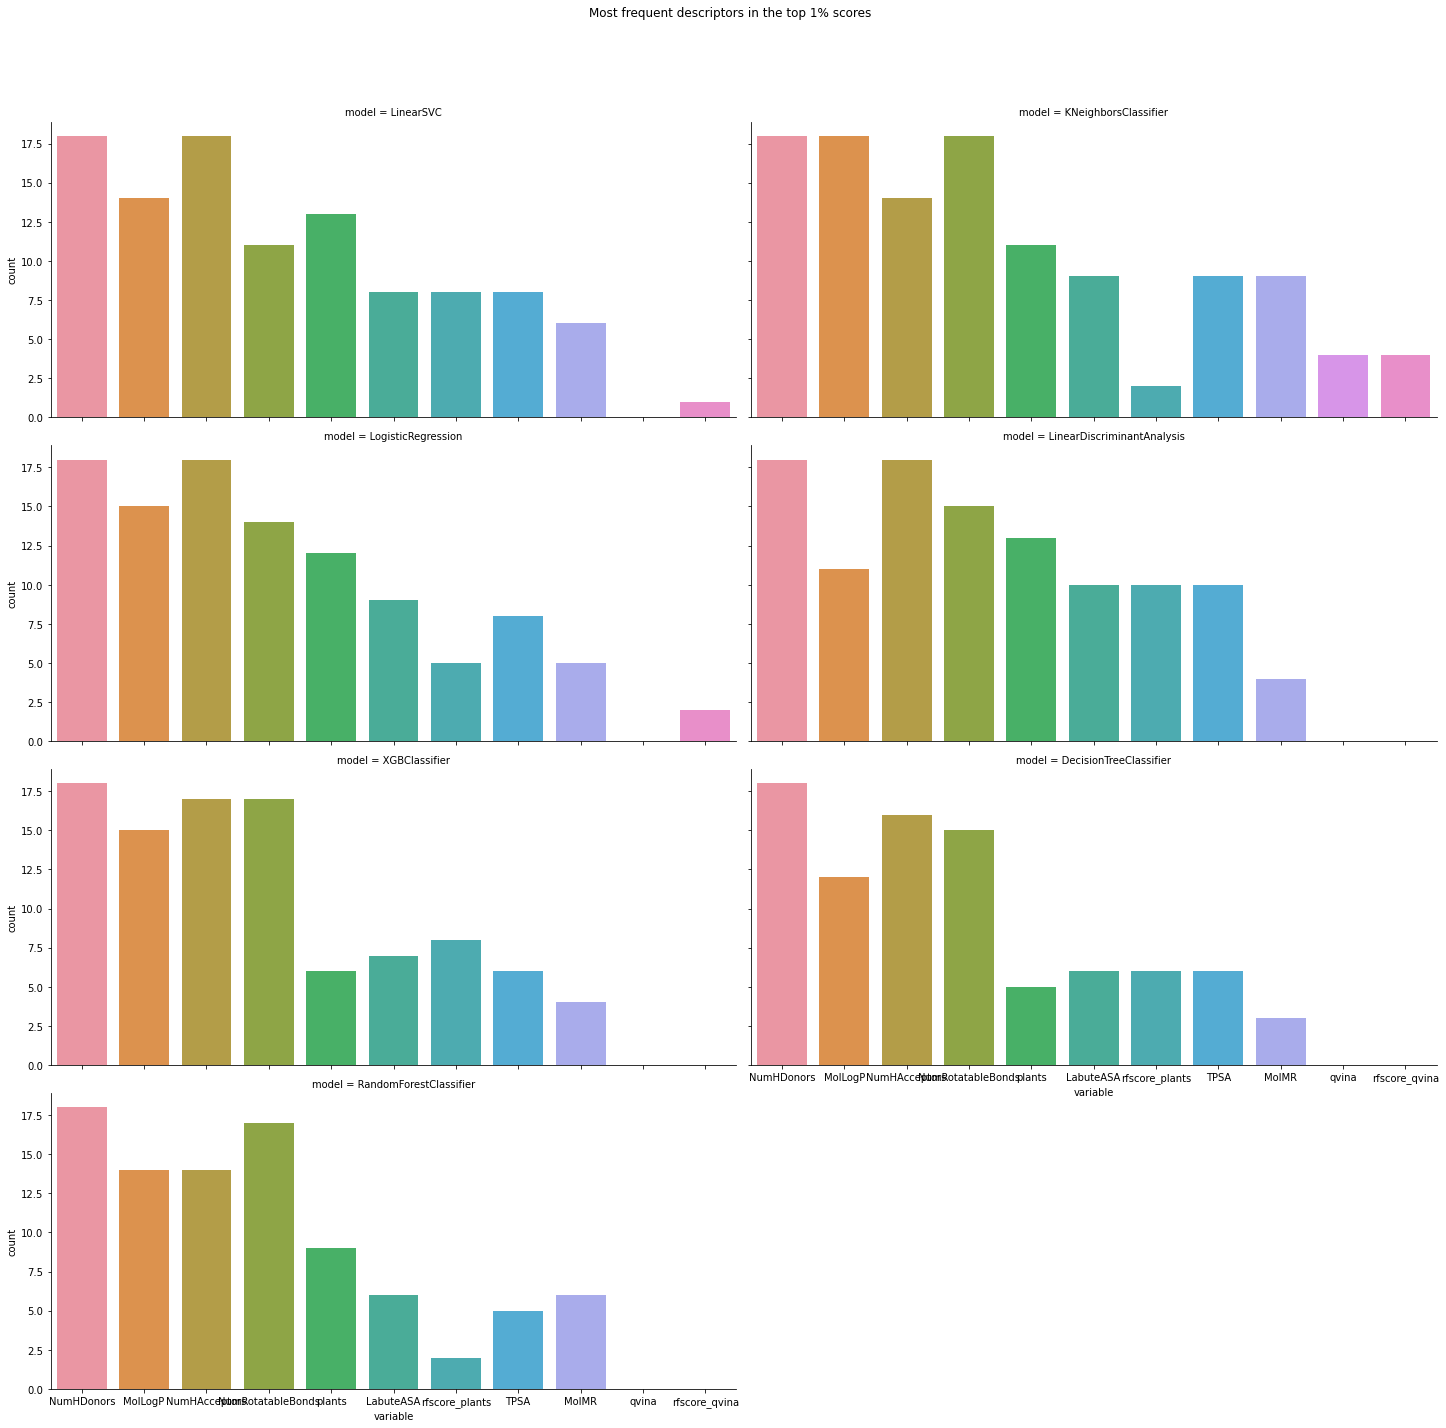

In [14]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=[*test_metrics,'activity_label','model','test_mean'], value_vars=trainset, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

g = sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', col_wrap=2, aspect=2)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Most frequent descriptors in the top 1% scores')

In [15]:
print('The frequency count shows the most recurring descriptors in each model\'s top 1% results are: ')
for key, value in best_subset.items():
    print(key, value)

The frequency count shows the most recurring descriptors in each model's top 1% results are: 
KNeighborsClassifier ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'qvina', 'rfscore_qvina']
LogisticRegression ['MolMR', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'rfscore_qvina']
LinearSVC ['MolMR', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'rfscore_qvina']
LinearDiscriminantAnalysis ['MolMR', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'rfscore_qvina']
XGBClassifier ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA', 'LabuteASA', 'MolLogP', 'rfscore_plants']
RandomForestClassifier ['NumRotatableBonds', 'NumHDonors']
DecisionTreeClassifier ['NumRotatableBonds', 'NumHDonors']


<a id='confusion_matrix'></a>
### Confusion matrix for the best model

In [16]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, log_loss

model_name = top_scores.sort_values('test_mean', ascending=False).iloc[0]['model']
subset = best_subset[model_name]

y = new_data[activity_label]
X = new_data[subset]

scaler = StandardScaler()
pipe = make_pipeline(SMOTE(random_state=42), scaler, XGBClassifier(objective='reg:logistic', random_state=13))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y): 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    break
    
pipe = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

#     Predicted   inactive |  active
# Actual 
# inactive      |    TN    |    FP    | 
# active        |    FN    |    TP    | 

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
matrix = pd.DataFrame(conf_matrix)

print(model_name)
print(f'RMSE: {np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test)):.4f}')
print(f'log_loss: {log_loss(y_test, y_proba):.4f}')
matrix

KNeighborsClassifier
RMSE: 0.3718
log_loss: 0.5144


,0,1
0,0.883436,0.116564
1,0.615385,0.384615


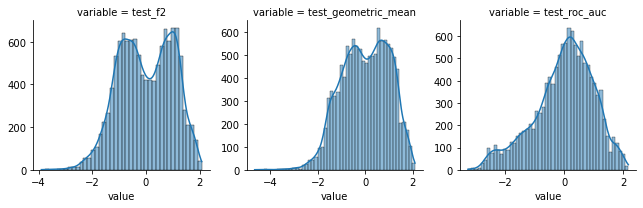

In [17]:
df = scores_data.copy()
df[test_metrics] = StandardScaler().fit_transform(scores_data[test_metrics])
tmp = pd.melt(df, value_vars=test_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)

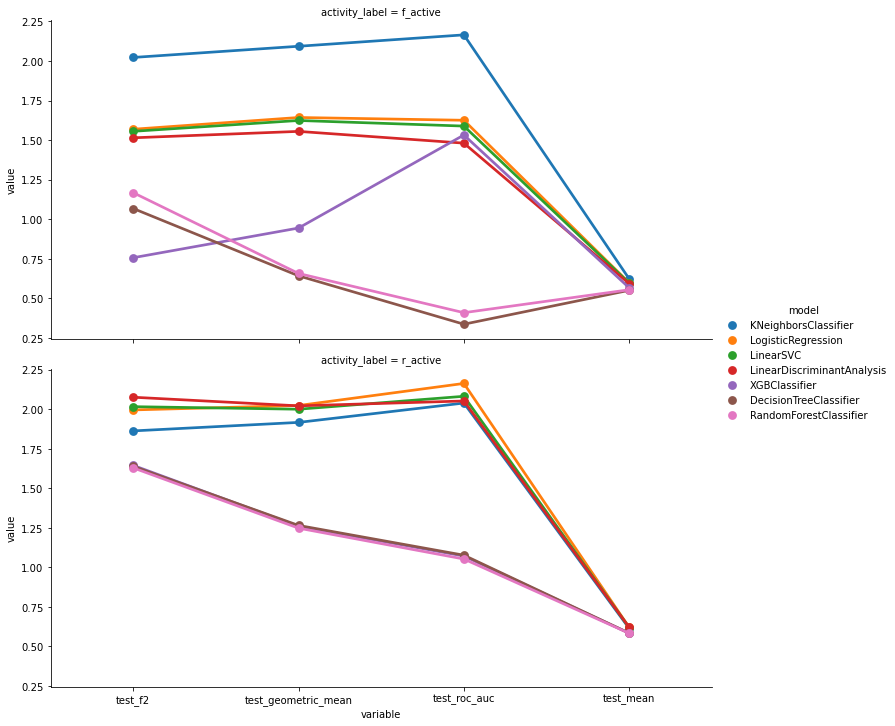

In [18]:
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2, order=[*test_metrics,'test_mean'])
plt.savefig('test_performance.png', dpi=216)

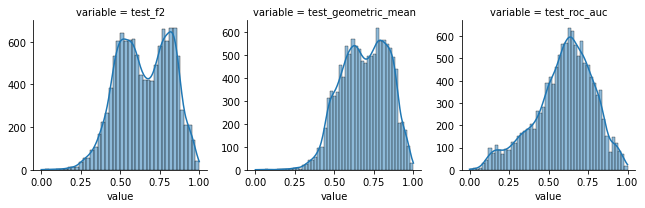

In [19]:
df = scores_data.copy()
df[test_metrics] = MinMaxScaler().fit_transform(scores_data[test_metrics])
tmp = pd.melt(df, value_vars=test_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)

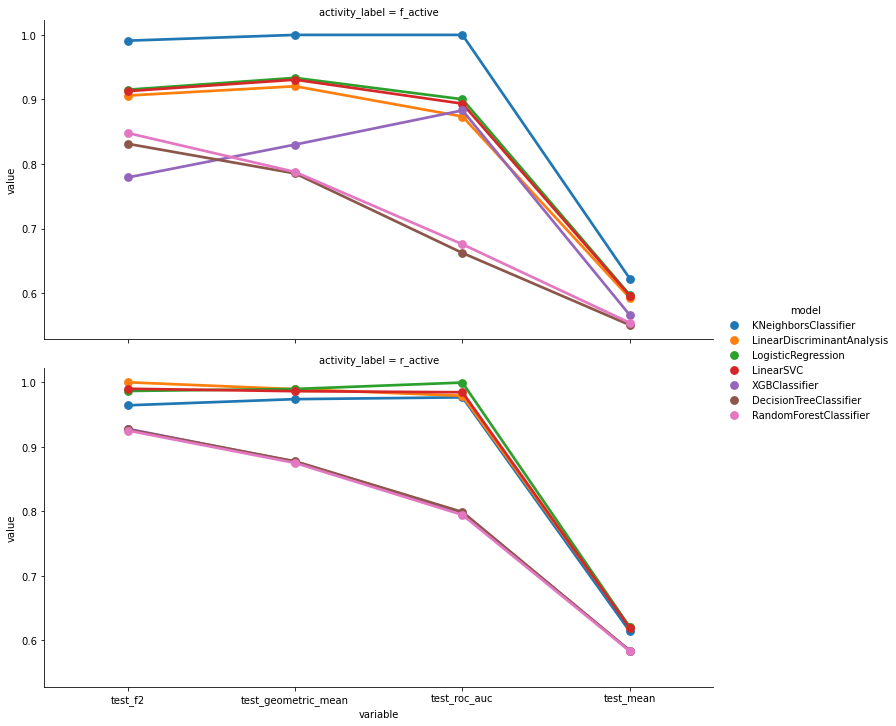

In [20]:
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2, order=[*test_metrics,'test_mean'])
plt.savefig('test_performance.png', dpi=216)

<a id='regression'></a>
### Regression plots

Text(0.5, 0.98, 'Regression plots for the test set')

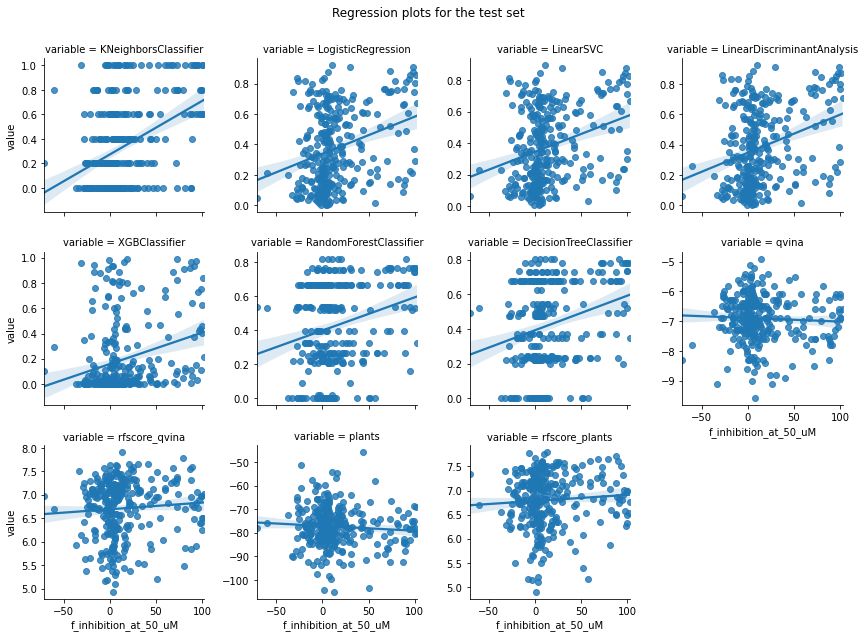

In [21]:
from scipy.stats import spearmanr

test_data['CID'] = data.loc[test_data.index]['CID']
tmp = pd.melt(test_data, id_vars=['CID'], value_vars=test_data.columns[:-1])
tmp = tmp.append(pd.melt(data.loc[test_data.index], id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants']))
df_tidy = pd.merge(data.loc[test_data.index][['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']], tmp, on=['CID'])

g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'f_inhibition_at_50_uM', 'value')

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Regression plots for the test set')

<a id='correlations'></a>
### Correlations

In [22]:
# Pearson correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='pearson')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.778507
f_inhibition_at_50_uM,0.778507,1.000000
DecisionTreeClassifier,0.337818,0.257200
KNeighborsClassifier,0.354331,0.427977
LinearDiscriminantAnalysis,0.352388,0.328657
LinearSVC,0.344706,0.320076
LogisticRegression,0.349123,0.321035
RandomForestClassifier,0.330503,0.249638
XGBClassifier,0.321596,0.283982


In [23]:
# Spearman correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='spearman')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.635991
f_inhibition_at_50_uM,0.635991,1.000000
DecisionTreeClassifier,0.355470,0.230769
KNeighborsClassifier,0.233380,0.348295
LinearDiscriminantAnalysis,0.267904,0.283379
LinearSVC,0.262436,0.277881
LogisticRegression,0.266121,0.279528
RandomForestClassifier,0.342064,0.215537
XGBClassifier,0.255521,0.265298
